## Comparing rest vs grpc protocol
### spoiled results as the timesleep is not consistent

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import json
from copy import deepcopy
import random
import sys
import time
from typing import List
from pprint import PrettyPrinter
pp = PrettyPrinter(indent=4)

# get an absolute path to the directory that contains parent files
project_dir = globals()['_dh'][0]
sys.path.append(os.path.normpath(os.path.join(
    project_dir, '..', '..', '..', '..')))

from experiments.utils.constants import (
    NODE_PROFILING_RESULTS_STATIC_PATH
)
from experiments.utils.loader import Loader

In [7]:
series = 39
experiment_id = 1
config_key_mapper = "key_config_mapper.csv"

series_path = os.path.join(
    NODE_PROFILING_RESULTS_STATIC_PATH,
    'series',
    str(series))
loader1 = Loader(
    series_path=series_path, config_key_mapper=config_key_mapper, second_node=False, type_of='node')
# loader2 = Loader(
#     series_path=series_path, config_key_mapper=config_key_mapper, second_node=False, type_of='node_with_log')
results_1 = loader1.result_processing()
# results_2 = loader2.result_processing()
key_config_df = loader1.key_config_mapper()
# print(results.columns)
# print(key_config_df.columns)
# results
display(key_config_df)

,experiment_id,pipeline_name,node_name,model_variant,cpu_request,memory_request,max_batch_size,max_batch_time,load,load_duration,series,series_meta,replicas,no_engine,protocol,data_type
0,1,6-mlserver-mock,mock-one,1,4,8Gi,1,1,100,60,39,rest vs grpc,1,False,rest,audio
1,2,6-mlserver-mock,mock-one,1,4,8Gi,1,1,1000,60,39,rest vs grpc,1,False,rest,audio
2,3,6-mlserver-mock,mock-one,1,4,8Gi,1,1,100,60,39,rest vs grpc,1,False,grpc,audio
3,4,6-mlserver-mock,mock-one,1,4,8Gi,1,1,1000,60,39,rest vs grpc,1,False,grpc,audio


In [8]:
results_1.sort_values(['experiment_id'])

,experiment_id,client_to_model_latencies_avg,client_to_model_latencies_p99,client_to_model_latencies_p50,client_to_model_latencies_var,client_to_model_latencies_max,client_to_model_latencies_min,model_latencies_avg,model_latencies_p99,model_latencies_p50,...,memory_usage_p50,memory_usage_var,memory_usage_max,memory_usage_min,throughput_avg,throughput_p99,throughput_p50,throughput_var,throughput_max,throughput_min
1,1,12.856583,21.787975,12.808927,29.155163,22.247770,0.554336,1.052784,1.239526,1.039731,...,8.048271e+08,9.524936e+16,8.840643e+08,228343808.0,24.385242,49.507134,24.494767,220.523243,49.973644,0.012733
3,2,156.040258,296.521608,156.834618,7045.309020,299.296339,0.554007,1.040185,1.159593,1.031765,...,8.583045e+08,3.115193e+16,1.420710e+09,228798464.0,61.574248,79.415378,74.172269,562.364464,79.529412,0.188717
2,3,4.404011,6.593243,4.630840,2.075820,6.824470,0.107156,1.018199,1.077412,1.015906,...,2.422661e+08,1.352756e+17,1.070461e+09,241819648.0,24.975902,49.520829,24.789141,210.582374,49.995346,0.955833
0,4,15.501852,37.994279,13.066419,106.760506,38.704877,0.100159,1.019419,1.085378,1.016588,...,1.123361e+09,2.212555e+17,1.207157e+09,229167104.0,30.988448,61.906893,31.523289,320.861633,62.580471,0.656683


In [9]:
configs = loader1.load_configs()
for config_name, config in configs.items():
    print(f"File name: {config_name}")
    pp.pprint(config) 

File name: 0.yaml
{   'cpu_request': ['4'],
    'data_type': 'audio',
    'max_batch_size': ['1'],
    'max_batch_time': ['1'],
    'memory_request': ['8Gi'],
    'model_variants': ['1'],
    'no_engine': False,
    'node_name': 'mock-one',
    'pipeline_name': '6-mlserver-mock',
    'protocol': 'rest',
    'repetition': 1,
    'replicas': [1],
    'series': 39,
    'series_meta': 'rest vs grpc',
    'timeout': 120,
    'workload_config': {'load_duration': 60, 'loads_to_test': [100, 1000]},
    'workload_type': 'static'}
File name: 1.yaml
{   'cpu_request': ['4'],
    'data_type': 'audio',
    'max_batch_size': ['1'],
    'max_batch_time': ['1'],
    'memory_request': ['8Gi'],
    'model_variants': ['1'],
    'no_engine': False,
    'node_name': 'mock-one',
    'pipeline_name': '6-mlserver-mock',
    'protocol': 'grpc',
    'repetition': 1,
    'replicas': [1],
    'series': 39,
    'series_meta': 'rest vs grpc',
    'timeout': 120,
    'workload_config': {'load_duration': 60, 'loads_t

In [11]:
model_variant = 1
experiment_ids = key_config_df[
    key_config_df['model_variant'] == 1]['experiment_id'].tolist()
metadata_columns = ['model_variant', 'max_batch_size', 'cpu_request', 'load', 'series_meta']
results_columns = ['timeout_count', 'client_to_model_latencies_avg', 'model_latencies_avg', 'model_to_client_latencies_avg']
output = loader1.table_maker(
    experiment_ids=experiment_ids,
    metadata_columns=metadata_columns,
    results_columns=results_columns)
display(output)
# ax = output.plot.bar(x='load', y=['client_to_model_latencies_avg', 'model_latencies_avg', 'model_to_client_latencies_avg'])
# ax.set_xlabel("Load")
# ax.set_ylabel("Latency (seconds)")

,model_variant,max_batch_size,cpu_request,load,series_meta,timeout_count,client_to_model_latencies_avg,model_latencies_avg,model_to_client_latencies_avg
0,1,1,4,100,rest vs grpc,1,12.856583,1.052784,0.022614
1,1,1,4,1000,rest vs grpc,35725,156.040258,1.040185,0.024588
2,1,1,4,100,rest vs grpc,0,4.404011,1.018199,0.007247
3,1,1,4,1000,rest vs grpc,53309,15.501852,1.019419,0.103657


,model_variant,max_batch_size,cpu_request,load,client_to_model_latencies_avg,model_latencies_avg,model_to_client_latencies_avg
0,1,1,4,100,12.856583,1.052784,0.022614
1,1,1,4,1000,156.040258,1.040185,0.024588
2,1,1,4,100,4.404011,1.018199,0.007247
3,1,1,4,1000,15.501852,1.019419,0.103657


Text(0, 0.5, 'Latency (seconds)')

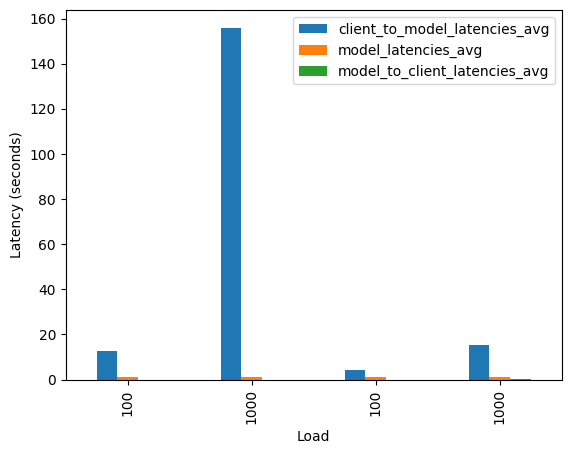

In [13]:
model_variant = 1
experiment_ids = key_config_df[
    key_config_df['model_variant'] == model_variant]['experiment_id'].tolist()
metadata_columns = ['model_variant', 'max_batch_size', 'cpu_request', 'load']
results_columns = ['client_to_model_latencies_avg', 'model_latencies_avg', 'model_to_client_latencies_avg']
output = loader1.table_maker(
    experiment_ids=experiment_ids,
    metadata_columns=metadata_columns,
    results_columns=results_columns)
display(output)
ax = output.plot.bar(x='load', y=['client_to_model_latencies_avg', 'model_latencies_avg', 'model_to_client_latencies_avg'])
ax.set_xlabel("Load")
ax.set_ylabel("Latency (seconds)")

,model_variant,max_batch_size,cpu_request,load,client_to_model_latencies_max,model_latencies_max,model_to_client_latencies_max
0,0,1,4,100,1.319601,1.069726,0.086862
1,0,1,4,1000,299.960467,1.085839,0.838348
2,0,1,4,100,0.751985,1.028600,0.030750
3,0,1,4,1000,299.466553,1.030543,0.976273
4,0,1,4,100,1.165963,0.530745,1.095512
5,0,1,4,1000,176.391342,2.444739,1.820172
6,0,1,4,100,79.080797,0.018909,2.692583
7,0,1,4,1000,298.688544,0.019275,3.342207
8,0,1,4,100,20.364210,0.674344,0.668720
9,0,1,4,1000,300.732788,0.712115,1.764605


Text(0, 0.5, 'Latency (seconds)')

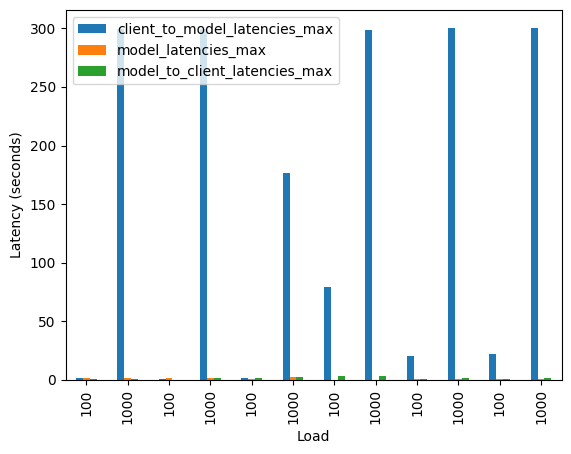

In [8]:
model_variant = 0
experiment_ids = key_config_df[
    key_config_df['model_variant'] == model_variant]['experiment_id'].tolist()
metadata_columns = ['model_variant', 'max_batch_size', 'cpu_request', 'load']
results_columns = ['client_to_model_latencies_max', 'model_latencies_max', 'model_to_client_latencies_max']
output = loader1.table_maker(
    experiment_ids=experiment_ids,
    metadata_columns=metadata_columns,
    results_columns=results_columns)
display(output)
ax = output.plot.bar(x='load', y=['client_to_model_latencies_max', 'model_latencies_max', 'model_to_client_latencies_max'])
ax.set_xlabel("Load")
ax.set_ylabel("Latency (seconds)")

In [9]:
import time
results = loader1.read_results()
experiment_id = 4
responses = loader1.flatten_results(results[str(experiment_id)]['responses'])
sending_times = []
for response in responses:
    try:
        sending_time = time.ctime(response['timing']['sending_time'])
        model_arrival_time = time.ctime(
        json.loads(
            response['outputs'][0][
                'data'][0])['time']['arrival_mock_one'])
        arrival_time = time.ctime(response['timing']['arrival_time'])
    except KeyError:
        # print('timed out!')
        pass
    print(f"sending time: {sending_time}, model_arrival_time: {model_arrival_time}, arrival time: {arrival_time}")

NameError: name 'model_arrival_time' is not defined